# Predicting further temperature rise in "buisness as usuall" CO2 emissions scenario

## Aim of this project is to predict further temperature rise in chosen cities around the world if the CO2 emission level do not change

In [19]:
# basic libraries
import pandas as pd
import numpy as np
import re
import random
from random import randrange

# plotting
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

# Timeseries prediction
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn import metrics

# stats
import scipy.stats as stats

# additional functions
from add_functions import *

# warnings
import warnings
warnings.filterwarnings("ignore")

In [3]:
# reading data

data = pd.read_csv(r"GlobalLandTemperaturesByCity.csv").dropna()
data.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
0,1743-11-01,6.068,1.737,Århus,Denmark,57.05N,10.33E
5,1744-04-01,5.788,3.624,Århus,Denmark,57.05N,10.33E
6,1744-05-01,10.644,1.283,Århus,Denmark,57.05N,10.33E
7,1744-06-01,14.051,1.347,Århus,Denmark,57.05N,10.33E
8,1744-07-01,16.082,1.396,Århus,Denmark,57.05N,10.33E


In [4]:
# creating "year" column for easier yearly mean calculation
# for date in data.dt:
data["year"] = [int(date[0:4]) for date in data.dt]
data.year

0          1743
5          1744
6          1744
7          1744
8          1744
           ... 
8599206    2013
8599207    2013
8599208    2013
8599209    2013
8599210    2013
Name: year, Length: 8235082, dtype: int64

<ipython-input-5-62ac74137474>:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.axes().xaxis.set_major_locator(plt.MaxNLocator(20))


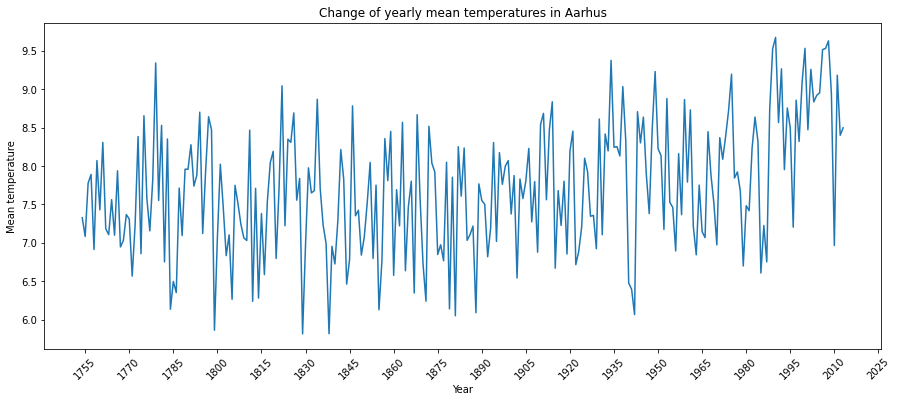

In [5]:
# Plotting yearly temperatures for Aarhus - first look

aarhus = data[data.City == "Århus"]
aarhus = aarhus[50:]
yearly = aarhus.groupby("year").mean()

plt.figure(figsize=(15,6))
plt.plot(yearly.index, yearly.AverageTemperature)
plt.xlabel("Year")
plt.ylabel("Mean temperature")
# limiting number of xticks 
plt.axes().xaxis.set_major_locator(plt.MaxNLocator(20))
plt.xticks(rotation=45)
plt.title("Change of yearly mean temperatures in Aarhus")
plt.show()

Plot for Aarhus shows that yearly mean temperatures have slightly risen. Test will show if this trend is present around the world

### Is the temperature in 2000s significantly higher than in 1900s?

In [6]:

# grouping data by city
data_grouped = data.groupby(["City","year"]).mean().reset_index()


In [7]:
# checking if mean temperatures in cities in datasets have changed using temperature_mean_change function
hotter, unchanged = temperature_mean_change(data_grouped)

In [8]:
# changing hotter into series for easier calculations
hotter_series = pd.Series(hotter)

In [9]:
# printinh out results
print(f"Out of {len(data_grouped.City.unique())} cities in dataset, in {len(hotter)} of them mean temperature between years 2000 and 2013 is significantly higher than between 1900 and 1990.")
print(f"This makes {len(data_grouped.City.unique())/len(hotter)*100} percent of the dataset")
print(f"City with highest mean temperature change is {hotter_series.idxmax()} in {data[data.City==hotter_series.idxmax()].Country.iloc[0]} with change of {hotter_series.max()}")
print(f"City with lowest mean temperature change is {hotter_series.idxmin()} in {data[data.City==hotter_series.idxmin()].Country.iloc[0]} with change of {hotter_series.min()}")

Out of 3448 cities in dataset, in 3448 of them mean temperature between years 2000 and 2013 is significantly higher than between 1900 and 1990.
This makes 100.0 percent of the dataset
City with highest mean temperature change is Engels in Russia with change of 1.901936813186813
City with lowest mean temperature change is Juliaca in Peru with change of 0.2560533424908433


Statistical tests have shown that in all of the cities mean temperatures have significantly risen in relation to mean from XX century. There is no place on earth without temperature rise. In the worst case temperature has almost crossed the 2 celcius rise border already, as for 2012.

## Choosing cities for more detailed analisys and plotting data

In [10]:
# choosing countries for analisys -- aiming for variety

countries = ["Norway","Ireland","Italy","Mexico","Peru","Ethiopia","Nigeria","South Korea","India","New Zealand","Jordan","Iran"]

In [11]:
data_chosen = data[data.Country.isin(countries)]

In [12]:
# choosing cities for analisys:
cities = []
for country in countries:
    data_country = data_chosen[data_chosen.Country == country]
    city = random.choice(list(data_country.City.unique()))
    cities.append(city)

In [13]:
list(cities)

['Oslo',
 'Cork',
 'Venice',
 'Guadalupe',
 'Tacna',
 'Awassa',
 'Hadejia',
 'Seoul',
 'Palanpur',
 'Christchurch',
 'Irbid',
 'Kashan']

In [14]:
# creating dataframe with data only for chosen cities
data_cities = data_chosen[data_chosen.City.isin(cities)]
# replacing longitude and latitude with numerical values
data_cities = translate_coordinates(data_cities)

C:\Users\szklarnia\anaconda3\lib\site-packages\pandas\core\indexing.py:1636: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\szklarnia\anaconda3\lib\site-packages\pandas\core\indexing.py:691: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


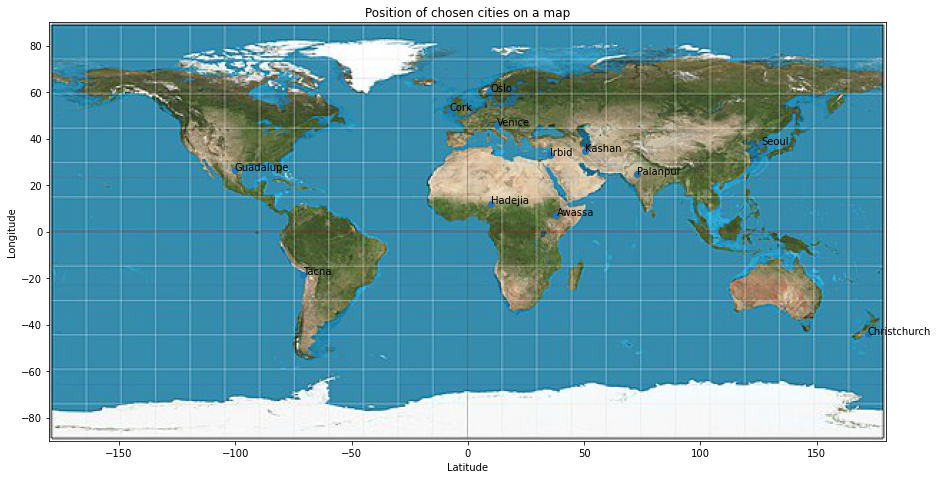

In [15]:
# Showing geographical locations of chosen cities on a world map
# updating cities variable to have same order
cities = data_cities.City.unique()
# loading image - map
world_map = mpimg.imread("world.jpg")
# creating list of longitudes
longitudes = [x for x in list(data_cities.Longitude.unique())]
# multiple cities on one latitude, different method
latitudes = []
for city in cities:
    latitudes.append(data_cities[data_cities.City == city].Latitude.iloc[0])

# plotting
plt.figure(figsize=(15,10))
plt.scatter(longitudes,latitudes)
# adding labels for points on map
for i, txt in enumerate(cities):
    plt.annotate(txt, (longitudes[i], latitudes[i]))
# showing map image
plt.imshow(world_map, extent=[-180.00, 180.00, -90, 90.00])
plt.ylabel("Longitude")
plt.xlabel("Latitude")
plt.title("Position of chosen cities on a map")
plt.show()


In [21]:
# creating dictionary with dataframes for each city for easier access
cities_dict = {}

for city in cities:
    data_city = data_cities[data_cities.City == city]
    
    # dropping data from years where there are gaps in data (less than 12 values)
    by_years = data_city.groupby("year").size()
    years_to_drop = []
    for year in list(by_years.index):
        if by_years[year] != 12:
            years_to_drop.append(year)
    data_city.drop(data_city[data_city.year.isin(years_to_drop)].index,inplace=True)        

    
    
    # adding resulting dataframe to a dictionary
    cities_dict[city] = data_city


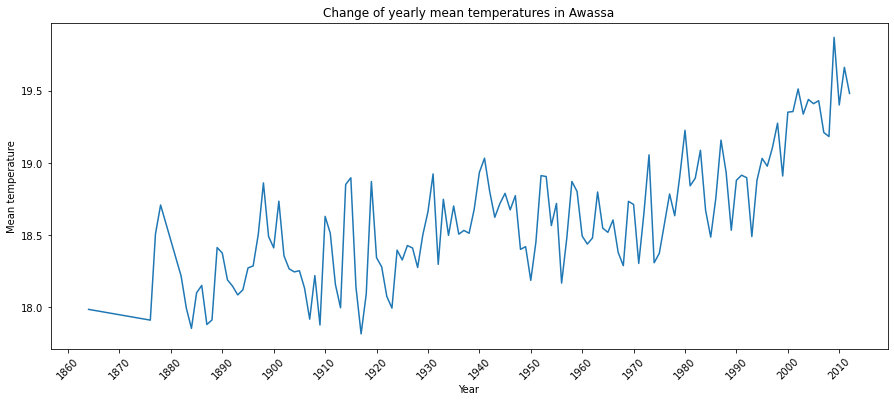

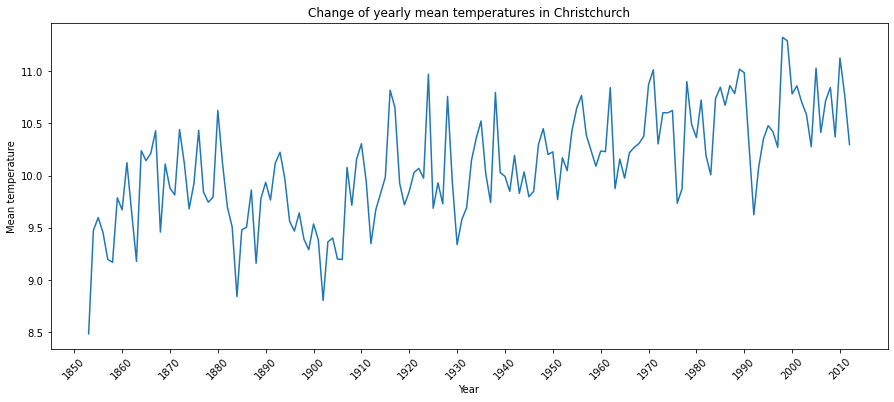

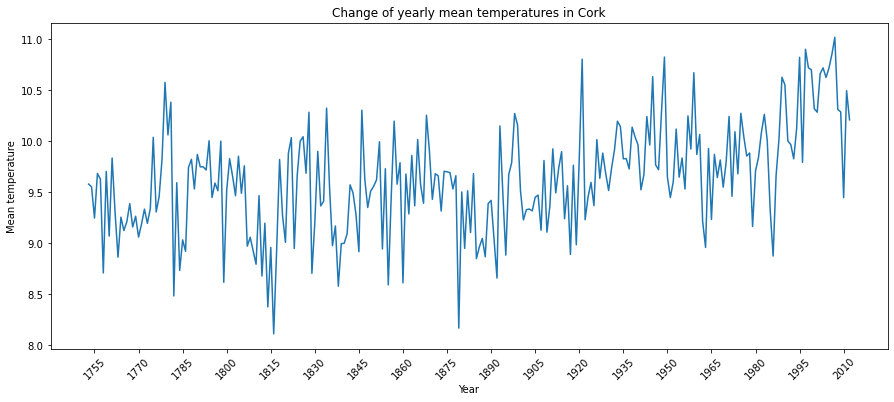

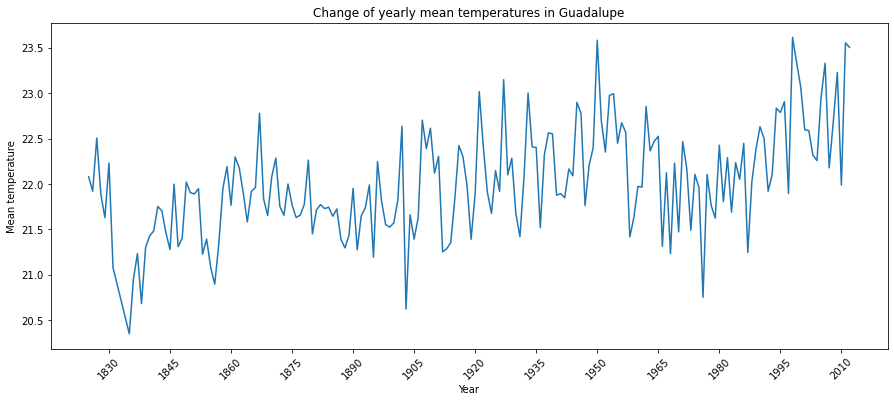

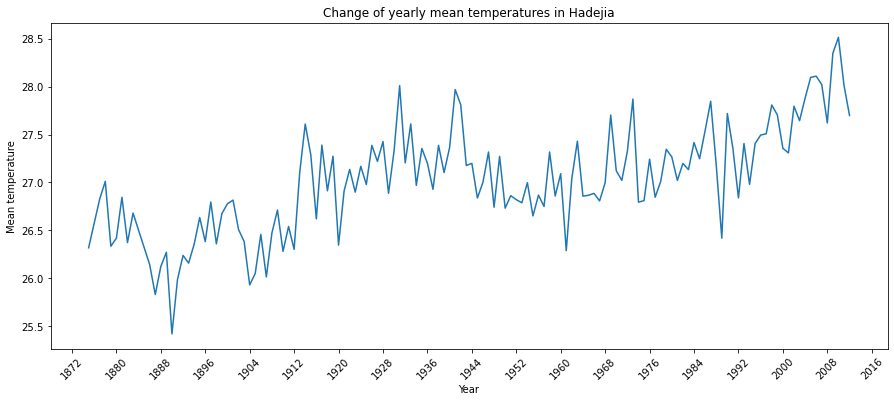

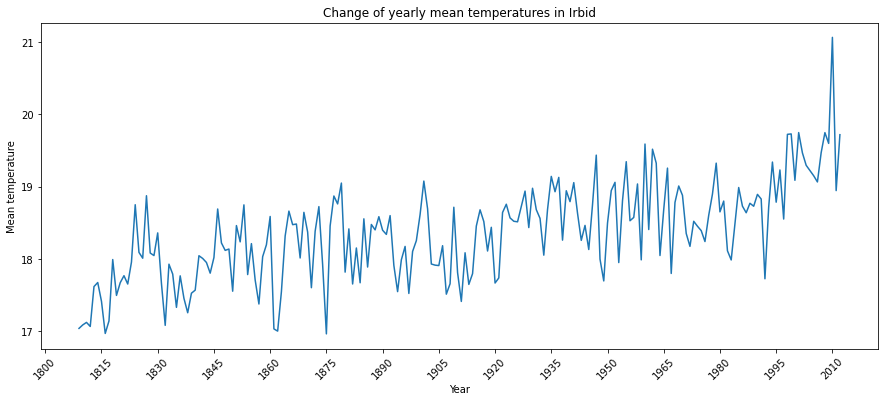

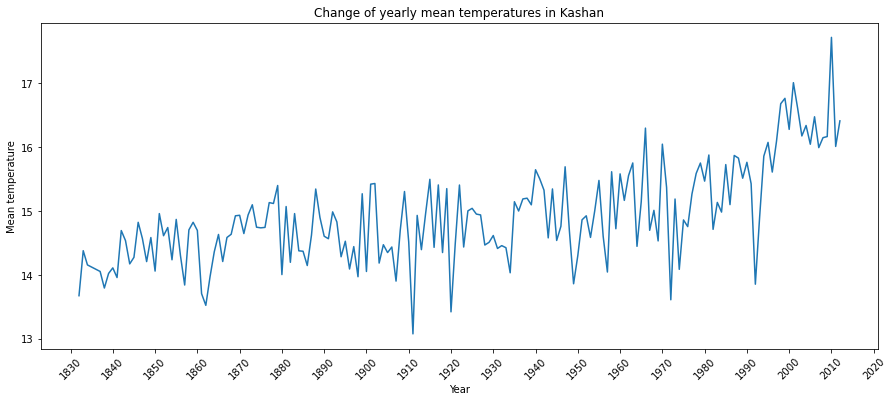

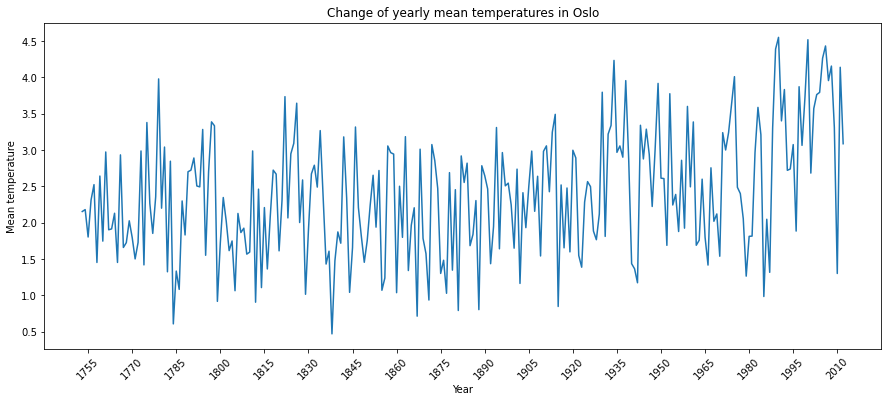

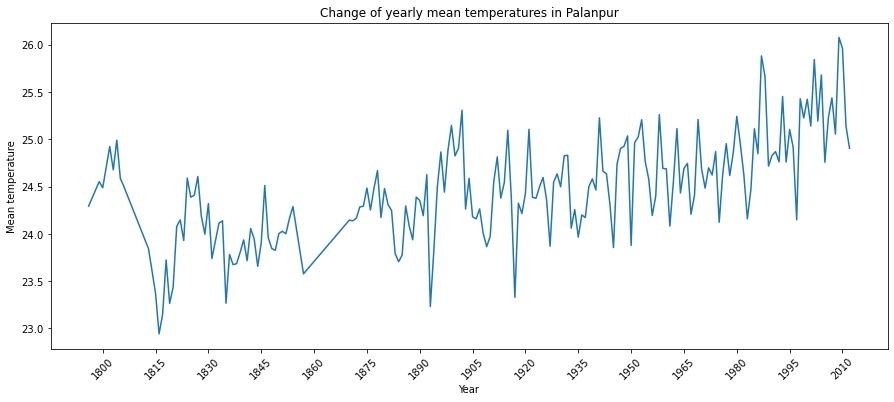

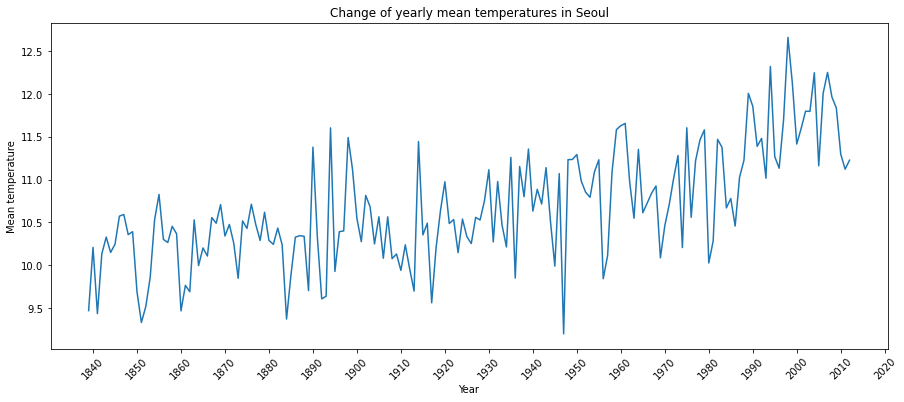

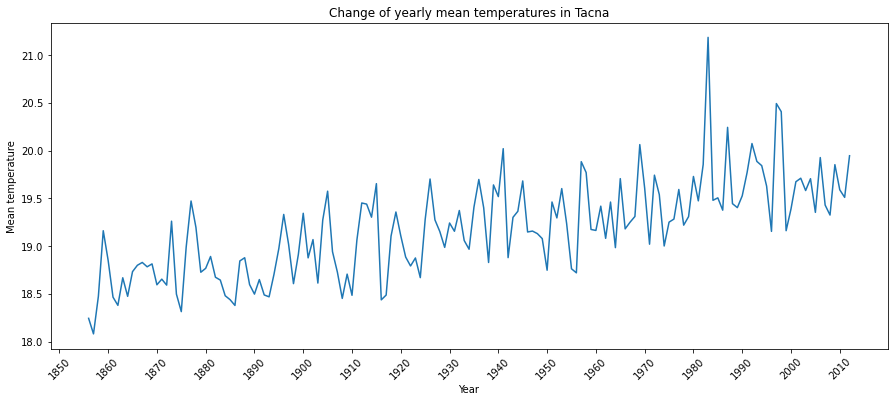

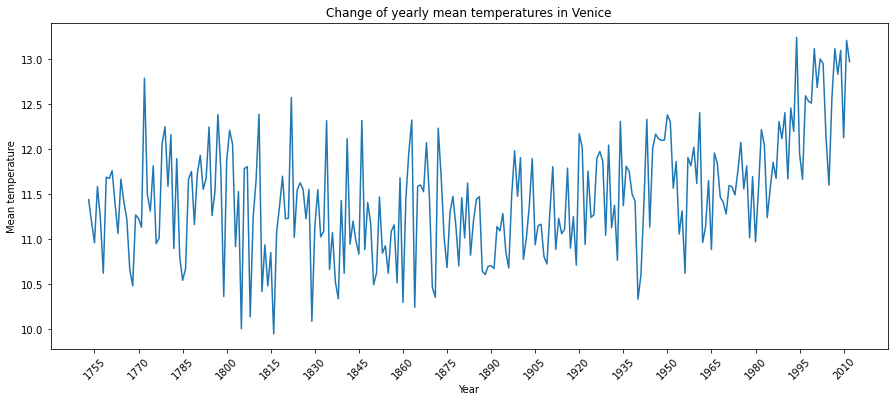

In [22]:
# plotting yearly mean temperatures for chosen cities

# iterating over cities
for key in cities_dict.keys():
    # creating yearly means for each place
    data_city = cities_dict[key]
    yearly = data_city.groupby("year").mean()
    
    # plotting
    plt.figure(figsize=(15,6))
    plt.plot(yearly.index, yearly.AverageTemperature)
    plt.xlabel("Year")
    plt.ylabel("Mean temperature")
    # limiting number of ticks showing on x axis
    plt.axes().xaxis.set_major_locator(plt.MaxNLocator(20))
    plt.xticks(rotation=45)
    plt.title(f"Change of yearly mean temperatures in {key}")

plt.show()

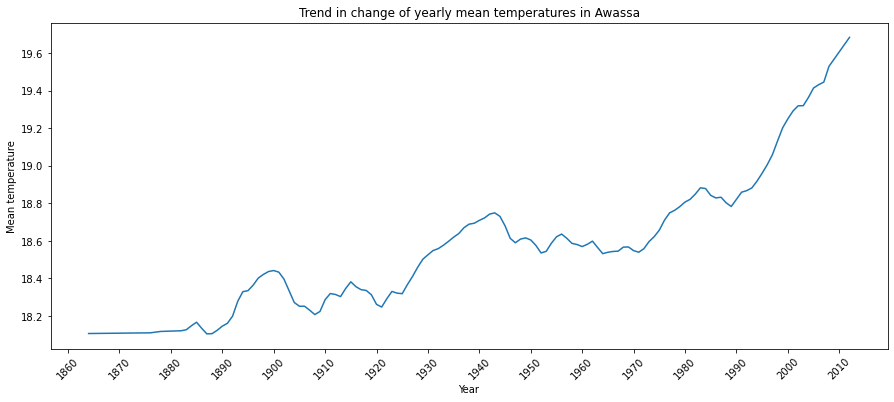

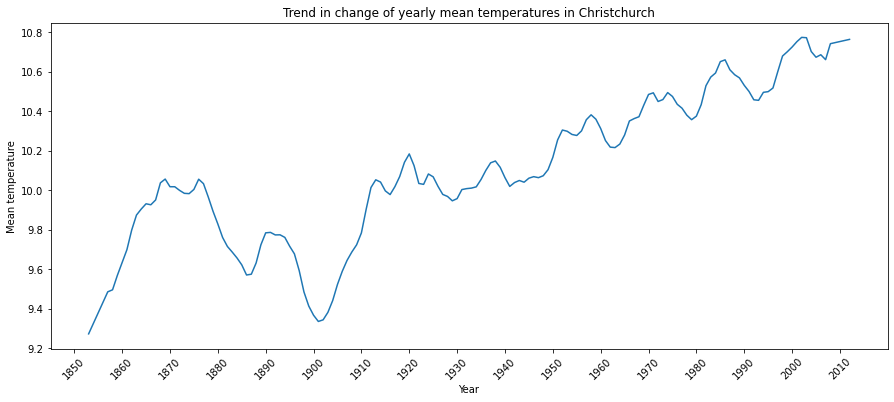

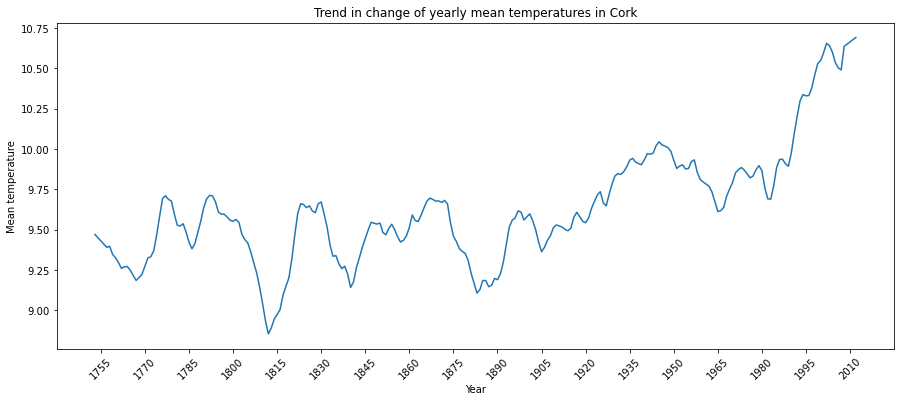

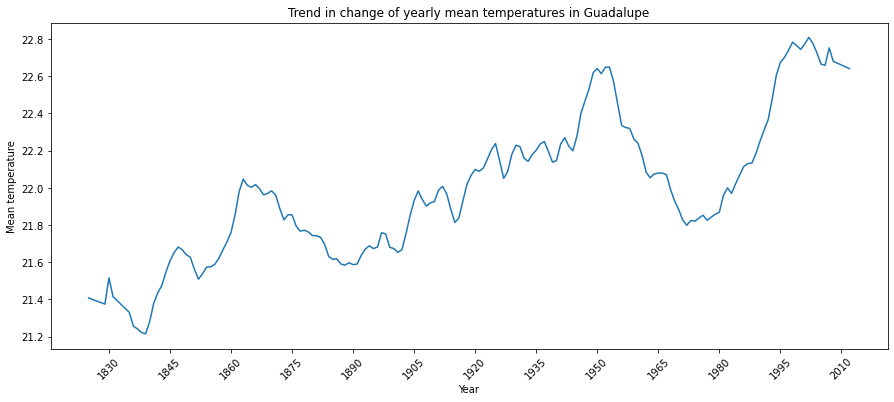

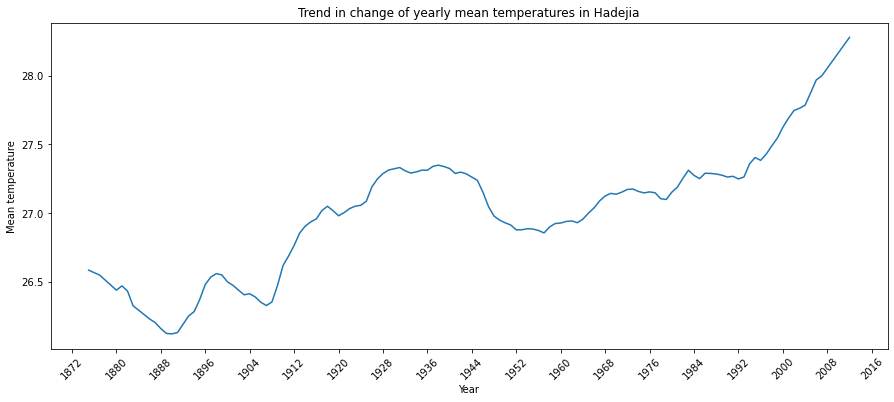

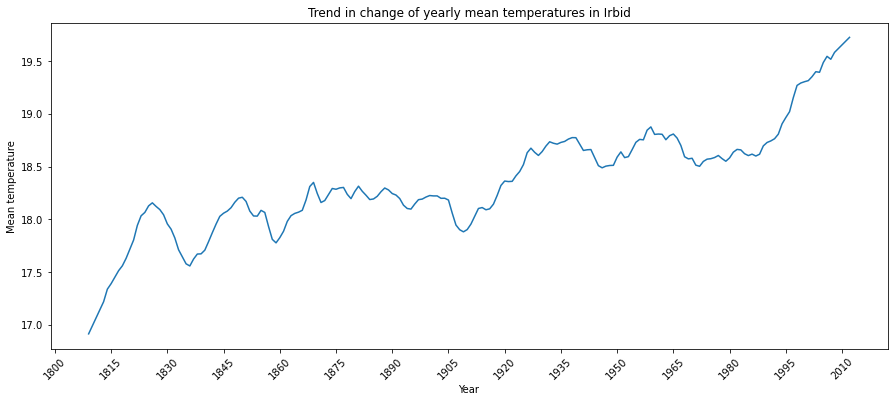

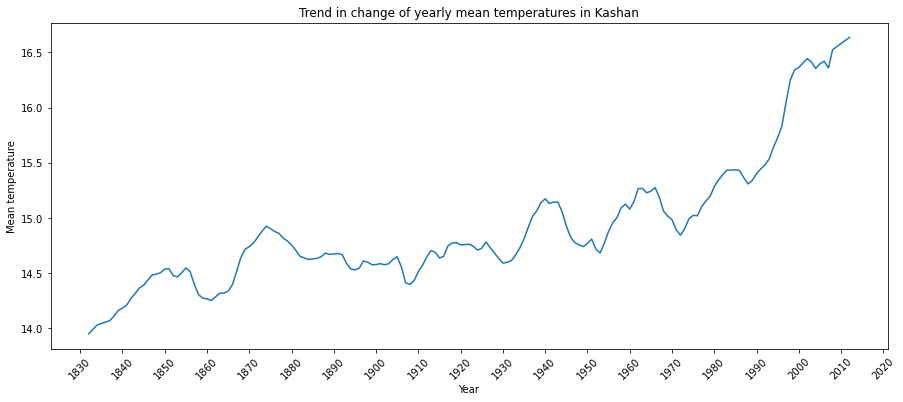

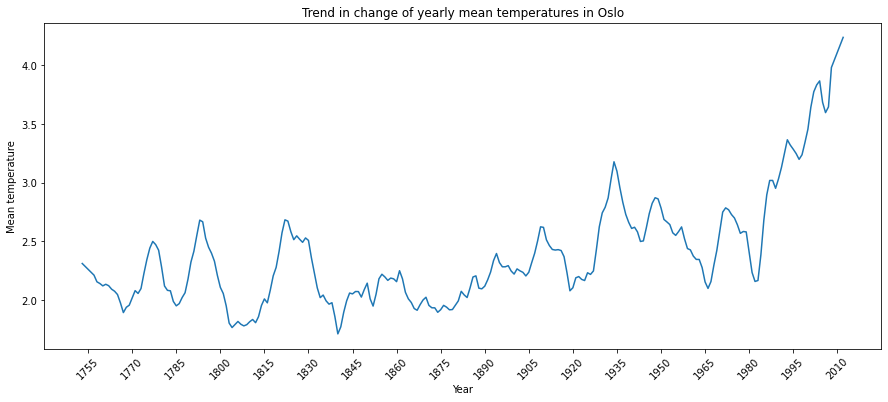

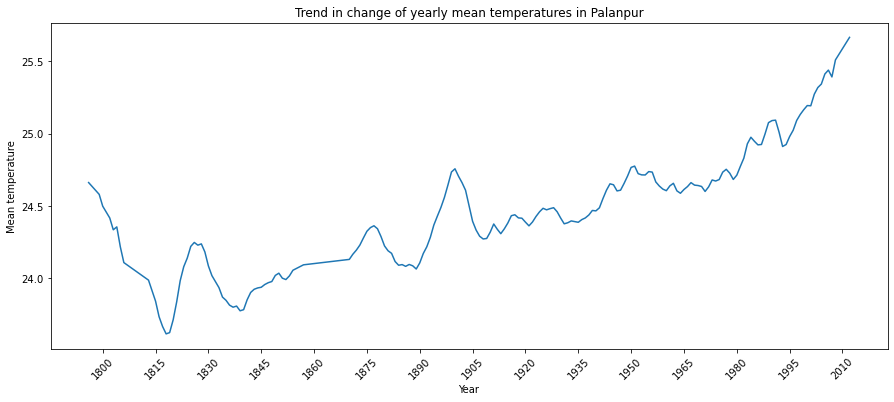

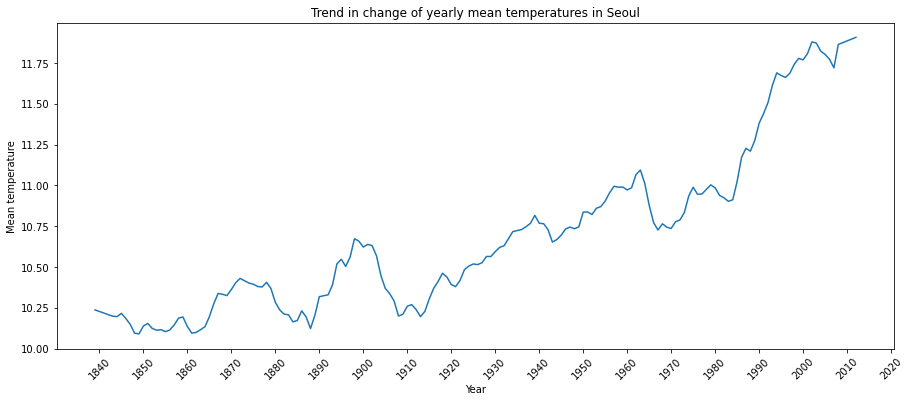

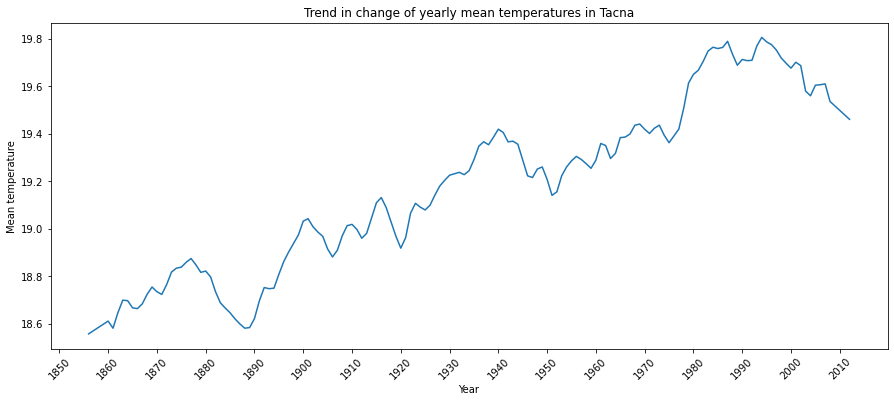

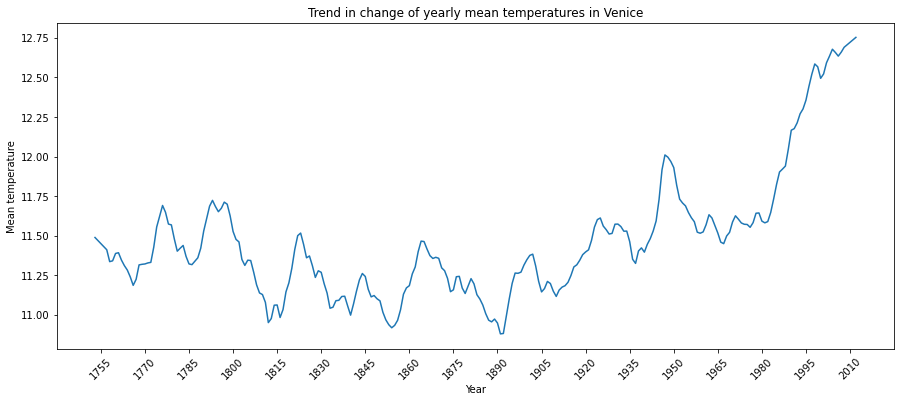

In [23]:
# plotting trends for each city

# iterating over cities
for key in cities_dict.keys():
    # creating yearly means
    data_city = cities_dict[key]
    yearly = data_city.groupby("year").mean()
    # decomposing timeseries
    result = seasonal_decompose(yearly.AverageTemperature, model='additive',period=10, extrapolate_trend='freq')    
    
    # plotting results
    plt.figure(figsize=(15,6))
    plt.plot(yearly.index, result.trend)
    plt.xlabel("Year")
    plt.ylabel("Mean temperature")
    # limiting number of x ticks showing
    plt.axes().xaxis.set_major_locator(plt.MaxNLocator(20))
    plt.xticks(rotation=45)
    plt.title(f"Trend in change of yearly mean temperatures in {key}")

plt.show()

Plots show clear rising trend over the years, in most of them rising sharply after 1980 and continuing to present. Only in Tacna, Peru there is small trend breakdown

## ARIMA prediction of further temperature rise

In [24]:

# creating list of arima orders to test and a dictionary to save best one for each city
orders = [(x,y,z) for x in range(4) for y in range(3) for z in range(3)]
best_orders = {}

# iterating over cities
for key in cities_dict.keys():
    # creating timeseries for prediction
    series = cities_dict[key].groupby("year").mean()["AverageTemperature"]
    #progress tracking
    print(key)
    # looking for the best order via find_best_order function - creating ARIMA models for orders, checking against naive prediction threshold
    best_order = find_best_order(orders,series)
    best_orders[key] = best_order


Awassa
(0, 0, 0)
(0, 0, 1)
(0, 0, 2)
(0, 1, 0)
(0, 1, 1)
(0, 1, 2)
(0, 2, 0)
(0, 2, 1)
(0, 2, 2)
(1, 0, 0)
(1, 0, 1)
(1, 0, 2)
(1, 1, 0)
(1, 1, 1)
(1, 1, 2)
(1, 2, 0)
(1, 2, 1)
(1, 2, 2)
(2, 0, 0)
(2, 0, 1)
(2, 0, 2)
(2, 1, 0)
(2, 1, 1)
(2, 1, 2)
(2, 2, 0)
(2, 2, 1)
(2, 2, 2)
(3, 0, 0)
(3, 0, 1)
(3, 0, 2)
(3, 1, 0)
(3, 1, 1)
(3, 1, 2)
(3, 2, 0)
(3, 2, 1)
(3, 2, 2)
Christchurch
(0, 0, 0)
(0, 0, 1)
(0, 0, 2)
(0, 1, 0)
(0, 1, 1)
(0, 1, 2)
(0, 2, 0)
(0, 2, 1)
(0, 2, 2)
(1, 0, 0)
(1, 0, 1)
(1, 0, 2)
(1, 1, 0)
(1, 1, 1)
(1, 1, 2)
(1, 2, 0)
(1, 2, 1)
(1, 2, 2)
(2, 0, 0)
(2, 0, 1)
(2, 0, 2)
(2, 1, 0)
(2, 1, 1)
(2, 1, 2)
(2, 2, 0)
(2, 2, 1)
(2, 2, 2)
(3, 0, 0)
(3, 0, 1)
(3, 0, 2)
(3, 1, 0)
(3, 1, 1)
(3, 1, 2)
(3, 2, 0)
(3, 2, 1)
(3, 2, 2)
Cork
(0, 0, 0)
(0, 0, 1)
(0, 0, 2)
(0, 1, 0)
(0, 1, 1)
(0, 1, 2)
(0, 2, 0)
(0, 2, 1)
(0, 2, 2)
(1, 0, 0)
(1, 0, 1)
(1, 0, 2)
(1, 1, 0)
(1, 1, 1)
(1, 1, 2)
(1, 2, 0)
(1, 2, 1)
(1, 2, 2)
(2, 0, 0)
(2, 0, 1)
(2, 0, 2)
(2, 1, 0)
(2, 1, 1)
(2, 1, 2)
(2, 2, 0)
(2, 2

In [23]:
key

'Seoul'

In [25]:
best_orders

{'Awassa': (3, 1, 0),
 'Christchurch': (0, 1, 2),
 'Cork': (0, 1, 1),
 'Guadalupe': (0, 1, 1),
 'Hadejia': (0, 1, 1),
 'Irbid': (0, 1, 1),
 'Kashan': (0, 1, 1),
 'Oslo': (2, 1, 1),
 'Palanpur': (1, 1, 1),
 'Seoul': (0, 1, 2),
 'Tacna': (2, 1, 1),
 'Venice': (0, 1, 1)}

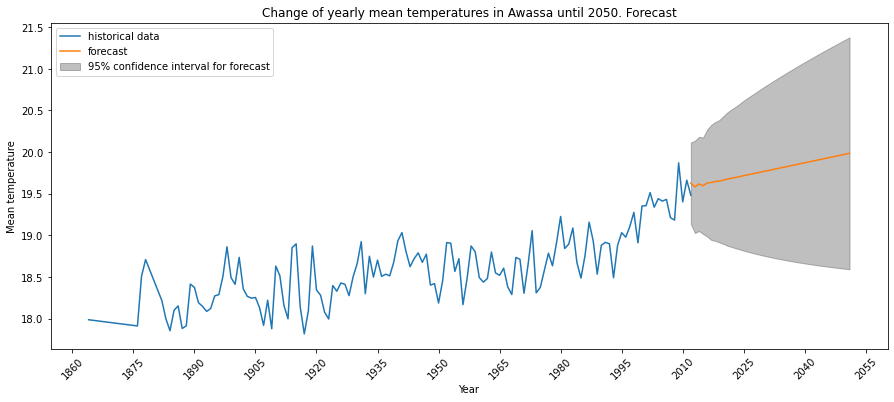

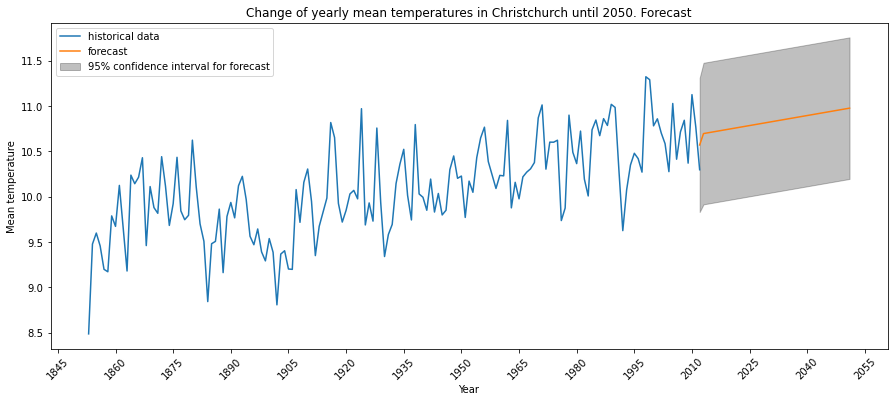

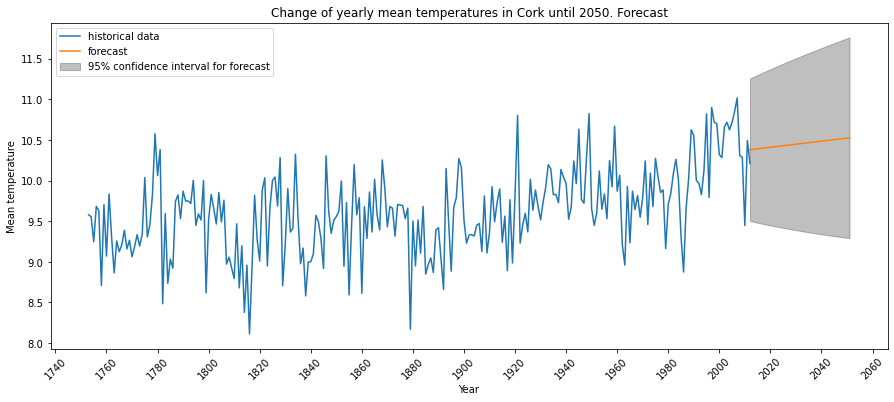

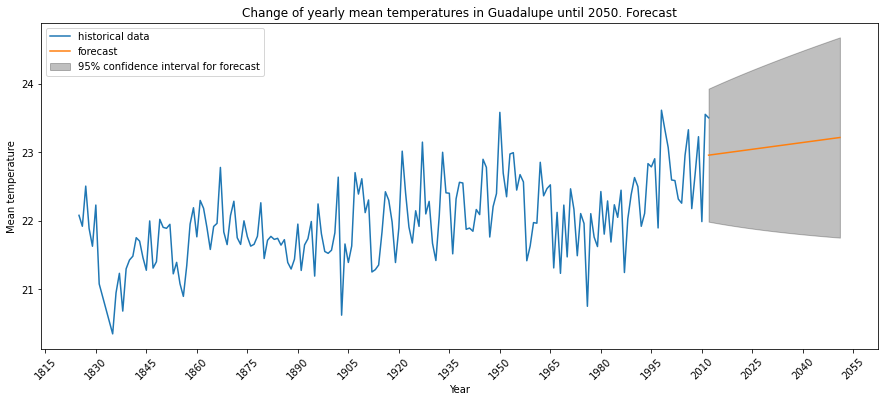

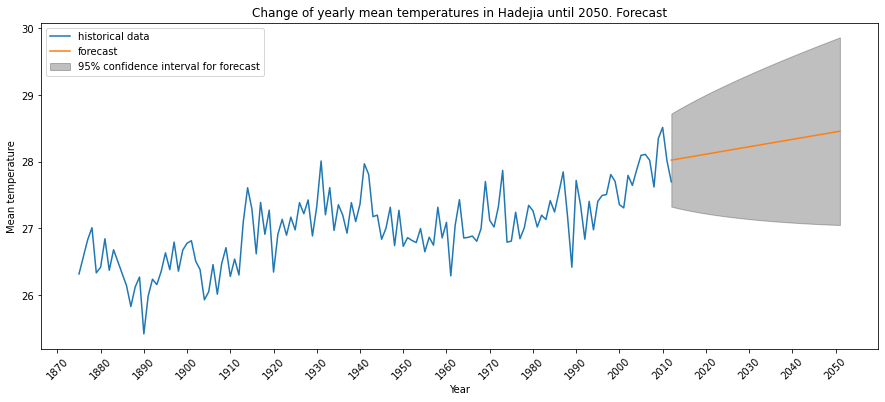

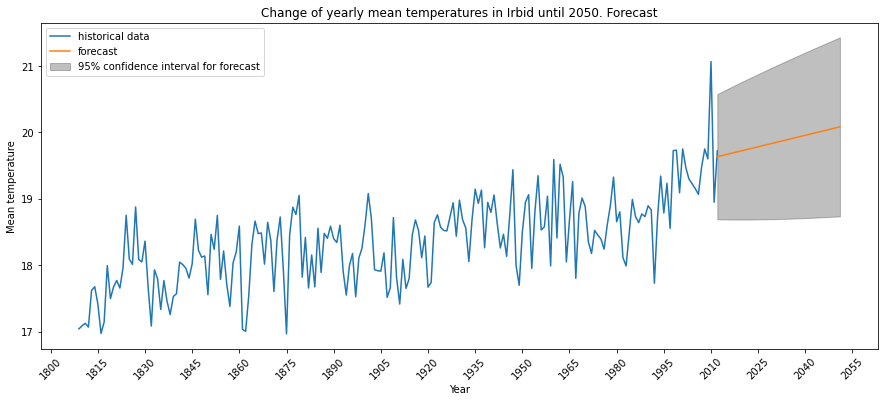

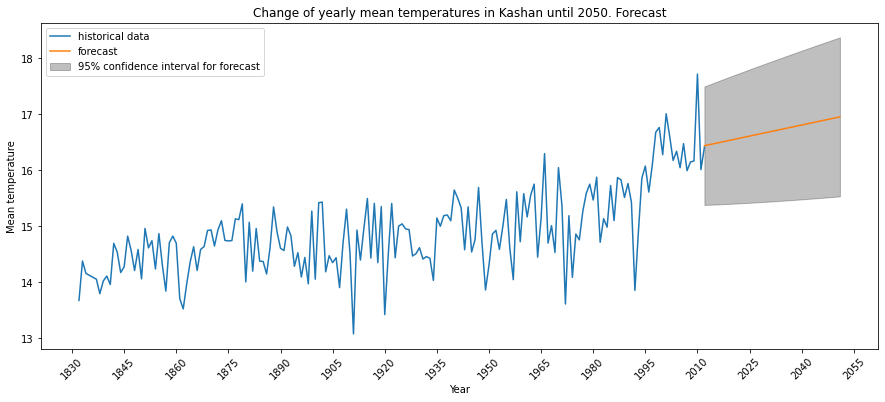

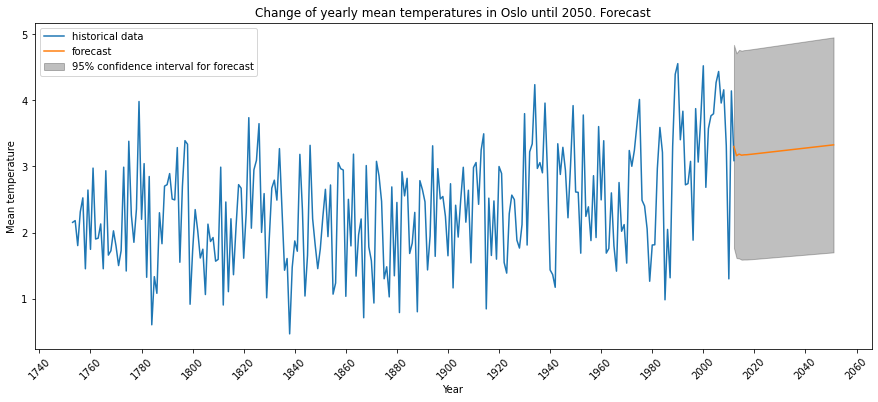

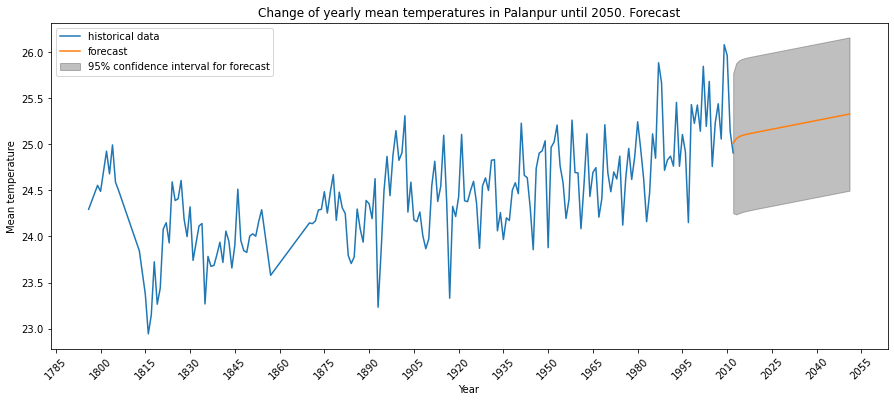

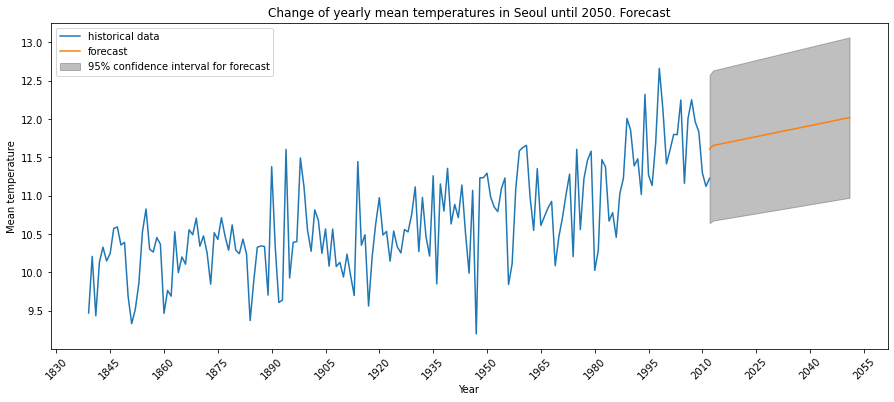

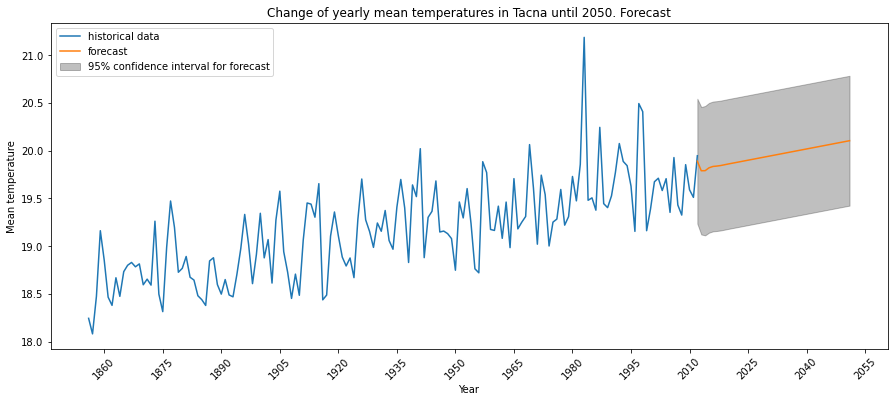

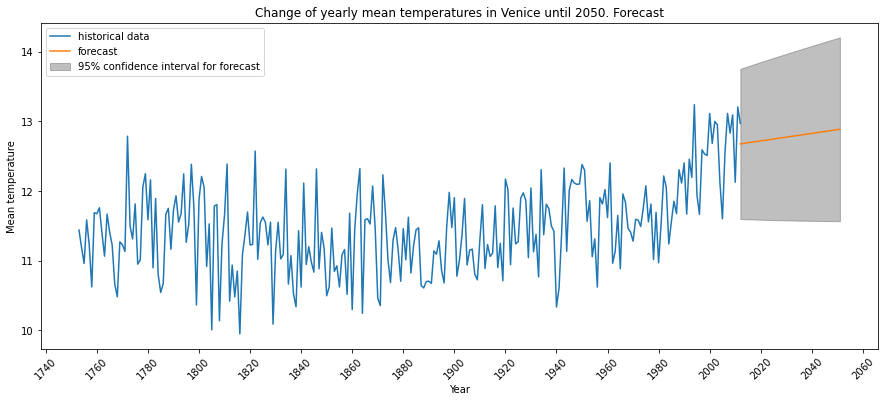

In [73]:
# using best model to forecast mean temperatures in 2050
temp_2050 = {}
#iterating over city - model pairs
for key, value in best_orders.items():
    # creating variables
    X = cities_dict[key].groupby("year").mean()["AverageTemperature"]
    order = best_orders[key]
    # fitting model
    model = ARIMA(X,order)
    model_fit = model.fit()
    fc,de, confint = model_fit.forecast(40)
    fc_idx = np.arange(X.index[-1],X.index[-1]+40)
    fc_series = pd.Series(fc,index=fc_idx)
    lower_series = pd.Series(confint[:, 0], fc_idx)
    upper_series = pd.Series(confint[:, 1], fc_idx)
    temp_2050[key] = fc_series.iloc[-1]
    
    # plotting forecast
    # creating timeseries for plotting
    # plotting
    plt.show()
    plt.figure(figsize=(15,6))
    plt.plot(X,label = "historical data")
    plt.plot(fc_series,label = "forecast")
    plt.fill_between(lower_series.index,
                lower_series,
                upper_series, color='k', alpha=.25, label = "95% confidence interval for forecast")
    plt.xlabel("Year")
    plt.ylabel("Mean temperature")
    # limiting number of ticks showing on x axis
    plt.axes().xaxis.set_major_locator(plt.MaxNLocator(20))
    plt.xticks(rotation=45)
    plt.legend(loc="upper left")
    plt.title(f"Change of yearly mean temperatures in {key} until 2050. Forecast")
    plt.show()
    

All plots indicate further rise in temperatures around the globe with current trends

In [68]:
temp_1950 = data_grouped[(data_grouped.year>=1900)&(data_grouped.year<1950)]

In [69]:
means_1950 = temp_1950.groupby("City").mean()["AverageTemperature"]

In [71]:
for city in cities:
    temperature = round((temp_2050[city]-means_1950[city]),2)
    print(f"Temperature in {city} in 2050 will be {temperature} higher than in the first half of XX century")

Temperature in Awassa in 2050 will be 1.53 higher than in the first half of XX century
Temperature in Christchurch in 2050 will be 1.04 higher than in the first half of XX century
Temperature in Cork in 2050 will be 0.81 higher than in the first half of XX century
Temperature in Guadalupe in 2050 will be 1.14 higher than in the first half of XX century
Temperature in Hadejia in 2050 will be 1.46 higher than in the first half of XX century
Temperature in Irbid in 2050 will be 1.68 higher than in the first half of XX century
Temperature in Kashan in 2050 will be 2.21 higher than in the first half of XX century
Temperature in Oslo in 2050 will be 0.81 higher than in the first half of XX century
Temperature in Palanpur in 2050 will be 0.86 higher than in the first half of XX century
Temperature in Seoul in 2050 will be 1.5 higher than in the first half of XX century
Temperature in Tacna in 2050 will be 0.96 higher than in the first half of XX century
Temperature in Venice in 2050 will be 1

## Conclusions

Models constructed for 12 different randomly chosen sites around the world indicate, that the temperatures are going to rise further, in some cases even breaking 2 celcius border. These analyses are based only on TimeSeries prediction, and do not take into account many variables that could further accalerate the process. Nevertheless it shows that if decisive action is not undertaken, climate on earth is going to continue changing drastically, and consequences could be catastrofical